In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

%config InlineBackend.figure_format = 'svg'  # improves the quality of graphs
%matplotlib inline
sns.set()

In [2]:
# change rdata to csv file
# from pyreadr import read_r
# rdata = read_r('customer_performance.RData')
# print(rdata.keys())
# df = pd.DataFrame()
# df = rdata['customer_performance']
# df.tail()
# df.to_csv('customer_performance.csv')

odict_keys(['customer_performance'])


In [2]:
# load the data into pandas data frames
# parse dates according to data dictionary from the task
# don't set indexes because we are not sure if the data has no duplicates
customer_performance = pd.read_csv('customer_performance.csv',
                                   parse_dates=['dates'],
                                   usecols=['dates', 'customer_id', 'late_ratio',
                                            'late_ratio_90', 'late_ratio_180'])

invoices = pd.read_csv(r'Data_Sample\\customer_invoices.csv', 
                       parse_dates=['status_datetime',
                                    'invoice_date',
                                    'payment_due_date'])

customer_master = pd.read_csv(r'Data_Sample\\client_customer_map.csv')

In [3]:
# print out basic information about datasets 
print('Customer Performance:')
print(customer_performance.info())
print('\nInvoices:')
print(invoices.info())
print('\nCustomer Master:')
print(customer_master.info())

Customer Performance:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121675 entries, 0 to 121674
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dates           121675 non-null  datetime64[ns]
 1   customer_id     121675 non-null  int64         
 2   late_ratio      121675 non-null  float64       
 3   late_ratio_90   121675 non-null  float64       
 4   late_ratio_180  121675 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 4.6 MB
None

Invoices:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623396 entries, 0 to 623395
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   gardenia_invoice_id         623396 non-null  float64       
 1   invoice_version             623396 non-null  int64         
 2   invoice_description         572942 n

### TASK 1

#### a. Find invoices which have more than one “entered” event. Record IDs of those removed,  if any. Remove all events for these invoices from the customer_invoices

In [4]:
# TASK 1
# a. Find invoices which have more than one “entered” event. Record IDs of those removed, 
# if any. Remove all events for these invoices from the customer_invoices

# get a subset of the invoices with status "entered"
entered_invoices = invoices[invoices['invoice_status'] == 'entered']

In [5]:
# mark duplicated values
double_entered_bool = entered_invoices.duplicated(keep=False)

# get a subset of invoices that have 1 or more duplicates by invoice ID and status
double_entered = entered_invoices[double_entered_bool]
print(f'There are {len(double_entered)} duplicated invoices that have more than one "entered" event based on all of the columns')

There are 0 duplicated invoices that have more than one "entered" event based on all of the columns


In [6]:
print('Lets look at the invoices that have duplicates based on invoice id and status:')
double_entered_bool_sub = entered_invoices.duplicated(subset=['gardenia_invoice_id', 'invoice_status'], keep=False)
double_entered_sub = entered_invoices[double_entered_bool_sub]
print(f'There are {len(double_entered_sub)} invoices that have more than one "entered" event.')

Lets look at the invoices that have duplicates based on invoice id and status:
There are 273 invoices that have more than one "entered" event.


In [7]:
duplicate_invoice_ids = double_entered_sub.gardenia_invoice_id.unique()
print(f'There are {len(duplicate_invoice_ids)} unique invoices among those 273.')
print(duplicate_invoice_ids)

There are 78 unique invoices among those 273.
[3100000. 3170000. 3180000. 3190000. 3200000. 3210000. 3520000. 3530000.
 3540000. 3550000. 3580000. 3590000. 3600000. 3610000. 3620000. 3630000.
 3640000. 3650000. 3660000. 3670000. 3690000. 3700000. 3720000. 3730000.
 3760000. 3770000. 3780000. 3820000. 3840000. 3860000. 3870000. 3880000.
 3890000. 3900000. 3910000. 3920000. 3930000. 3940000. 3960000. 3970000.
 3980000. 3990000. 4000000. 4010000. 4020000. 4030000. 4040000. 4050000.
 4060000. 4070000. 4080000. 4100000. 4120000. 4130000. 4140000. 4150000.
 4160000. 4170000. 4180000. 4190000. 4200000. 4210000. 4220000. 4240000.
 4250000. 4260000. 4280000. 4300000. 4310000. 4320000. 4330000. 4350000.
 4370000. 4380000. 4390000. 4410000. 4430000. 4440000.]


In [8]:
# drop entries where we have duplicated_invoice_ids
new_invoices = invoices[~invoices['gardenia_invoice_id'].isin(duplicate_invoice_ids)]
print(f'new_invoices data frame without ids with multiple "entered" status is by {len(invoices) - len(new_invoices)}'
      f' entries smaller')

new_invoices data frame without ids with multiple "entered" status is by 546 entries smaller


#### b. For each invoice, events with a higher invoice_version should have a status_datetime >= than the previous ones. Find invoices with events that fail this condition, if any, and record their IDs. Remove events for these invoices from the updated customer_invoices.

In [10]:
# b. For each invoice, events with a higher invoice_version should have a status_datetime >= than the
# previous ones. Find invoices with events that fail this condition, if any, and record their IDs.
# Remove events for these invoices from the updated customer_invoices.

# find invoices where the status_datetime on newer version is older
# sort invoices by id and their version and put in a new datafrmae
sorted_invoices = new_invoices.sort_values(['gardenia_invoice_id', 'invoice_version'])

# per invoice id, get the difference between status_datetime x and x-1 and record rows whith negative results
incorrect_version_date = sorted_invoices[sorted_invoices.groupby('gardenia_invoice_id')['status_datetime'].apply(lambda x: x.diff(1)).astype('timedelta64[D]') < 0]
print(incorrect_version_date)

Empty DataFrame
Columns: [gardenia_invoice_id, invoice_version, invoice_description, invoice_status, related_document, customer_id, status_datetime, invoice_amount, invoice_currency, invoice_date, payment_due_date, client_region, input_source, input_user, input_doc_type, client_accounting_currency, payment_method, payment_terms]
Index: []


In [11]:
print('the data frame is empty which means that there are no invoices that have newer version with older status_datetime')

the data frame is empty which means that there are no invoices that have newer version with older status_datetime


#### c. Filter out the “adjusted” events from the remaining customer_invoices, as we won’t need them further for this exercise

In [12]:
# c. Filter out the “adjusted” events from the remaining customer_invoices, as we won’t need them
# further for this exercise

# select all the rows where invoice status is not adjusted
filtered_invoices = new_invoices[new_invoices.invoice_status != 'adjusted']
print(f'we filtered {len(new_invoices) - len(filtered_invoices)} entries from the data frame')

we filtered 2110 entries from the data frame


In [13]:
# to verify which values we might have in invoice status column
filtered_invoices['invoice_status'].unique()

array(['entered', 'paid'], dtype=object)

#### d. Sanity check: find the first and last dates for all datetime fields. Record them and check they look sensible.

In [14]:
# d. Sanity check: find the first and last dates for all datetime fields. 
# Record them and check they look sensible.
print(f'First date in status datetime column: ', min(filtered_invoices['status_datetime']))
print(f'Last date in status datetime column: ', max(filtered_invoices['status_datetime']))
print(f'\nFirst date in invoice date column: ', min(filtered_invoices['invoice_date']))
print(f'Last date in invoice date column: ', max(filtered_invoices['invoice_date']))
print(f'\nFirst date in payment due date column: ', min(filtered_invoices['payment_due_date']))
print(f'Last date in payment due date column: ', max(filtered_invoices['payment_due_date']))


First date in status datetime column:  2007-06-30 00:00:00
Last date in status datetime column:  2018-04-10 00:00:00

First date in invoice date column:  2006-12-31 00:00:00
Last date in invoice date column:  2018-03-30 00:00:00

First date in payment due date column:  2007-02-14 00:00:00
Last date in payment due date column:  2018-05-31 00:00:00


All the dates look reasonable in terms of abnormally high or low dates such as 2502-12-40. Although, the earliest 
date in status datetime is higher than the earliest dates in invoice date or payment due date columns.

According to the data dictionary, status datetime column records date when some event occured, so my expectation would be that payment due date should have the same date as status datetime or payment due date should be older than status datetime. Otherwise, this implies that the invoice due date was missed.

In [15]:
filtered_invoices[filtered_invoices['invoice_date'] == '2006-12-31']

gardenia_invoice_id  invoice_version invoice_description  \
921               3098968.0                1          MIBR146071   
922               3098968.0                2          MIBR037029   
949               3098984.0                1          MIBR156046   
950               3098984.0                2          MIBR156046   
67395             3544055.0                1          MIMU036518   
67396             3544055.0                2          MIMU036518   
67397             3544056.0                1          MIMU036566   
67398             3544056.0                2          MIMU036566   
67517             3544131.0                1          MIMU036567   
67518             3544131.0                2          MIMU036566   
67519             3544132.0                1          MIMU036568   
67520             3544132.0                2          MIMU036566   
67521             3544133.0                1          MIMU036569   
67522             3544133.0                2          MIMU036566   
67523             3544134.0                1          MIMU036570   
67524             3544134.0                2          MIMU036566   
67641             3544205.0                1          MIMU036621   
67642             3544205.0                2          MIMU036566   
67643             3544206.0                1          MIMU036628   
67644             3544206.0                2          MIMU036628   
69138             3545185.0                1          MIMU036529   
69140             3545185.0                3           CASHRECTS   
69720             3550847.0                1           Inv 11332   
69721             3550847.0                2           Inv 11332   
69722             3550849.0                1           Inv 11512   
69727             3550849.0                6               12673   
112495            3606088.0                1          MIMU036507   
112496            3606088.0                2          MIMU037413   

       invoice_status related_document  customer_id status_datetime  \
921           entered       MIBR146071     60000075      2007-06-30   
922              paid       MIBR146071     60000075      2007-07-27   
949           entered       MIBR156046     60000075      2007-06-30   
950              paid       MIBR156046     60000075      2008-05-21   
67395         entered       MIMU036518     61000089      2007-06-30   
67396            paid       MIMU036518     61000089      2008-10-21   
67397         entered       MIMU036566     61000089      2007-06-30   
67398            paid       MIMU036566     61000089      2008-05-28   
67517         entered       MIMU036567     61000089      2007-06-30   
67518            paid       MIMU036567     61000089      2008-05-28   
67519         entered       MIMU036568     61000089      2007-06-30   
67520            paid       MIMU036568     61000089      2008-05-28   
67521         entered       MIMU036569     61000089      2007-06-30   
67522            paid       MIMU036569     61000089      2008-05-28   
67523         entered       MIMU036570     61000089      2007-06-30   
67524            paid       MIMU036570     61000089      2008-05-28   
67641         entered       MIMU036621     61000089      2007-06-30   
67642            paid       MIMU036621     61000089      2008-05-28   
67643         entered       MIMU036628     61000089      2007-06-30   
67644            paid       MIMU036628     61000089      2007-07-31   
69138         entered       MIMU036529     61000089      2007-06-30   
69140            paid       MIMU036529     61000089      2008-08-13   
69720         entered        Inv 11332     66000079      2007-06-30   
69721            paid        Inv 11332     66000079      2008-03-12   
69722         entered        Inv 11512     66000079      2007-06-30   
69727            paid        Inv 11512     66000079      2007-12-13   
112495        entered       MIMU036507     61000089      2007-06-30   
112496           paid       MIMU036507     6100

Looking at the data that has the earliest date in invoice date, we can see that for all of the rows payment due dates are the same but status datetime column has many different values. Lets check whether selecting subset of data with the earliest date in invoice date would yield the same result as selecting the earliest date in payment due date column. 

In [16]:
filtered_invoices[filtered_invoices['invoice_date'] == '2006-12-31'].equals(filtered_invoices[filtered_invoices['payment_due_date'] == '2007-02-14'])

True

The results are identical.

### 2. Basic feature engineering and data normalisation

a. Create features for entered_date and paid_date (status_datetime for “entered” and “paid” events)

b. Convert the table of events into a table of invoices, preserving the entered_date and paid_date.

c. Create a feature for “Is_late” = if(payment_date > payment_due_date, 1, 0)

d. Create a feature for “Early_late_days” = payment_date – payment_due_date (in days)

so the final df should have the following columns:

`invoice_id` - unique invoice id (int)

`date_entered` - status datetime where invoice status == entered (datetime)

`date_paid` - status datetime where invoice status == paid (datetime)

`is_late` - 1 if late, 0 if not late (categorical) 

`early_late_dates` - payment_date - payment_due_date (in days)

#### a. Create features for entered_date and paid_date (status_datetime for “entered” and “paid” events)
#### b. Convert the table of events into a table of invoices, preserving the entered_date and paid_date.

In [17]:
# get subset of invoices with relevant columns 
invoices_subset = filtered_invoices[['gardenia_invoice_id', 'invoice_status', 'status_datetime']].copy()

In [18]:
invoices_subset.head()

gardenia_invoice_id invoice_status status_datetime
0            3094734.0        entered      2016-10-27
1            3094734.0           paid      2017-01-06
2            3094736.0        entered      2016-10-28
3            3094736.0           paid      2017-01-06
4            3094937.0        entered      2016-10-27

In [19]:
# create pivot table with invoice status as column name and status datetime as values
invoices_pivot = invoices_subset.pivot(index='gardenia_invoice_id', columns='invoice_status', values='status_datetime')

In [20]:
invoices_pivot.head()

invoice_status         entered       paid
gardenia_invoice_id                      
3094734.0           2016-10-27 2017-01-06
3094736.0           2016-10-28 2017-01-06
3094937.0           2016-10-27 2017-01-06
3094939.0           2016-10-27 2017-01-06
3094960.0           2016-10-27 2017-01-06

In [21]:
# change column names
invoices_pivot.columns = ['entered_date', 'paid_date']

In [22]:
invoices_pivot.head()

entered_date  paid_date
gardenia_invoice_id                        
3094734.0             2016-10-27 2017-01-06
3094736.0             2016-10-28 2017-01-06
3094937.0             2016-10-27 2017-01-06
3094939.0             2016-10-27 2017-01-06
3094960.0             2016-10-27 2017-01-06

#### c. Create a feature for “Is_late” = if(payment_date > payment_due_date, 1, 0)

In [23]:
invoices_merged = invoices_pivot.merge(filtered_invoices.set_index('gardenia_invoice_id')[['payment_due_date',
                                                                                          'customer_id',
                                                                                          'invoice_amount',
                                                                                          'client_region',
                                                                                          'payment_terms',
                                                                                           'client_accounting_currency'
                                                                                         ]],
                            left_index=True, right_index=True, how='inner').drop_duplicates(keep='first')

In [24]:
invoices_merged.head()

entered_date  paid_date payment_due_date  customer_id  \
gardenia_invoice_id                                                         
3094734.0             2016-10-27 2017-01-06       2016-12-26     60002624   
3094736.0             2016-10-28 2017-01-06       2016-12-27     60002624   
3094937.0             2016-10-27 2017-01-06       2016-12-26     60002624   
3094939.0             2016-10-27 2017-01-06       2016-12-26     60002624   
3094960.0             2016-10-27 2017-01-06       2016-12-26     60002624   

                     invoice_amount  client_region  payment_terms  \
gardenia_invoice_id                                                 
3094734.0                   2282.20             60              3   
3094736.0                  18831.29             60              3   
3094937.0                   1916.54             60              3   
3094939.0                    282.13             60              3   
3094960.0                  10395.92             60              3   

                    client_accounting_currency  
gardenia_invoice_id                             
3094734.0                                  GBP  
3094736.0                                  GBP  
3094937.0                                  GBP  
3094939.0                                  GBP  
3094960.0                                  GBP

In [25]:
invoices_merged['is_late'] = np.where(invoices_merged['payment_due_date'] < invoices_merged['paid_date'], 1, 0)

In [26]:
invoices_merged.head()

entered_date  paid_date payment_due_date  customer_id  \
gardenia_invoice_id                                                         
3094734.0             2016-10-27 2017-01-06       2016-12-26     60002624   
3094736.0             2016-10-28 2017-01-06       2016-12-27     60002624   
3094937.0             2016-10-27 2017-01-06       2016-12-26     60002624   
3094939.0             2016-10-27 2017-01-06       2016-12-26     60002624   
3094960.0             2016-10-27 2017-01-06       2016-12-26     60002624   

                     invoice_amount  client_region  payment_terms  \
gardenia_invoice_id                                                 
3094734.0                   2282.20             60              3   
3094736.0                  18831.29             60              3   
3094937.0                   1916.54             60              3   
3094939.0                    282.13             60              3   
3094960.0                  10395.92             60              3   

                    client_accounting_currency  is_late  
gardenia_invoice_id                                      
3094734.0                                  GBP        1  
3094736.0                                  GBP        1  
3094937.0                                  GBP        1  
3094939.0                                  GBP        1  
3094960.0                                  GBP        1

#### d. Create a feature for “Early_late_days” = payment_date – payment_due_date (in days)

In [27]:
invoices_merged['Early_late_days'] = invoices_merged['paid_date'] - invoices_merged['payment_due_date']

In [28]:
invoices_merged.head()

entered_date  paid_date payment_due_date  customer_id  \
gardenia_invoice_id                                                         
3094734.0             2016-10-27 2017-01-06       2016-12-26     60002624   
3094736.0             2016-10-28 2017-01-06       2016-12-27     60002624   
3094937.0             2016-10-27 2017-01-06       2016-12-26     60002624   
3094939.0             2016-10-27 2017-01-06       2016-12-26     60002624   
3094960.0             2016-10-27 2017-01-06       2016-12-26     60002624   

                     invoice_amount  client_region  payment_terms  \
gardenia_invoice_id                                                 
3094734.0                   2282.20             60              3   
3094736.0                  18831.29             60              3   
3094937.0                   1916.54             60              3   
3094939.0                    282.13             60              3   
3094960.0                  10395.92             60              3   

                    client_accounting_currency  is_late Early_late_days  
gardenia_invoice_id                                                      
3094734.0                                  GBP        1         11 days  
3094736.0                                  GBP        1         10 days  
3094937.0                                  GBP        1         11 days  
3094939.0                                  GBP        1         11 days  
3094960.0                                  GBP        1         11 days

In [29]:
# now we need to drop payment_due_date column
invoices_merged.drop(columns=['payment_due_date'], axis=1, inplace=True)

In [30]:
invoices_merged.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 256669 entries, 3094734.0 to 4450000.0
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   entered_date                256669 non-null  datetime64[ns] 
 1   paid_date                   256669 non-null  datetime64[ns] 
 2   customer_id                 256669 non-null  int64          
 3   invoice_amount              256669 non-null  float64        
 4   client_region               256669 non-null  int64          
 5   payment_terms               256669 non-null  int64          
 6   client_accounting_currency  256669 non-null  object         
 7   is_late                     256669 non-null  int32          
 8   Early_late_days             256669 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), int32(1), int64(3), object(1), timedelta64[ns](1)
memory usage: 18.6+ MB


### 3. Additional features

Join the cleaned customer_invoices and customer_customer_map to add customer level data. Hint:
Client_customer_id in the customer_invoices joins with the customer_id in the customer data.

Next, join the customer_performance.RData file to the invoices data. This table is keyed by customer id and
datetime. You need to join it on the customer_id and entered_date fields in the cleaned invoices table you
have created. To clarify, invoices from the same customer and date will get the same value.

In [31]:
customer_performance.head()

dates  customer_id  late_ratio  late_ratio_90  late_ratio_180
0 2007-07-13     50001712         0.0            0.0             0.0
1 2007-07-13     50002632         0.0            0.0             0.0
2 2007-07-13     50003240         0.0            0.0             0.0
3 2007-07-13     50003662         0.0            0.0             0.0
4 2007-07-13     50004048         0.0            0.0             0.0

In [32]:
invoices_merged.head()

entered_date  paid_date  customer_id  invoice_amount  \
gardenia_invoice_id                                                        
3094734.0             2016-10-27 2017-01-06     60002624         2282.20   
3094736.0             2016-10-28 2017-01-06     60002624        18831.29   
3094937.0             2016-10-27 2017-01-06     60002624         1916.54   
3094939.0             2016-10-27 2017-01-06     60002624          282.13   
3094960.0             2016-10-27 2017-01-06     60002624        10395.92   

                     client_region  payment_terms client_accounting_currency  \
gardenia_invoice_id                                                            
3094734.0                       60              3                        GBP   
3094736.0                       60              3                        GBP   
3094937.0                       60              3                        GBP   
3094939.0                       60              3                        GBP   
3094960.0                       60              3                        GBP   

                     is_late Early_late_days  
gardenia_invoice_id                           
3094734.0                  1         11 days  
3094736.0                  1         10 days  
3094937.0                  1         11 days  
3094939.0                  1         11 days  
3094960.0                  1         11 days

In [33]:
customer_master.head()

customer_id  client_customer_id  client_subentity client_customer_city  \
0            7            60000075                60            Camberley   
1            9            60000077                60           Manchester   
2          255            60002624                60                  NaN   
3          322            60001699                60               London   
4          403            60003169                60                 Avon   

  client_customer_region          payment_terms client_payment_instrument  
0                     GB  100%-30-Days/NA-NA-NA                         A  
1                     GB  100%-90-Days/NA-NA-NA                         A  
2                     GB  100%-60-Days/NA-NA-NA                         A  
3                     GB  100%-45-Days/NA-NA-NA                         A  
4                     GB  100%-60-Days/NA-NA-NA                         A

In [34]:
# join invoices merged with customer master (client_customer_map.csv) - join customer_id on client_customer_id
# as we can see above some columns have identical names but different data within them, so this should be fixed
invoices_merged = invoices_merged.rename({'customer_id': 'client_customer_id'}, axis=1)
customer_master = customer_master.rename({'payment_terms': 'customer_payment_terms'}, axis=1)

In [35]:
invoices_customers = invoices_merged.reset_index().merge(customer_master, on='client_customer_id', 
                                                         how='inner').set_index('gardenia_invoice_id').drop_duplicates()
invoices_customers.head()

entered_date  paid_date  client_customer_id  \
gardenia_invoice_id                                               
3094734.0             2016-10-27 2017-01-06            60002624   
3094736.0             2016-10-28 2017-01-06            60002624   
3094937.0             2016-10-27 2017-01-06            60002624   
3094939.0             2016-10-27 2017-01-06            60002624   
3094960.0             2016-10-27 2017-01-06            60002624   

                     invoice_amount  client_region  payment_terms  \
gardenia_invoice_id                                                 
3094734.0                   2282.20             60              3   
3094736.0                  18831.29             60              3   
3094937.0                   1916.54             60              3   
3094939.0                    282.13             60              3   
3094960.0                  10395.92             60              3   

                    client_accounting_currency  is_late Early_late_days  \
gardenia_invoice_id                                                       
3094734.0                                  GBP        1         11 days   
3094736.0                                  GBP        1         10 days   
3094937.0                                  GBP        1         11 days   
3094939.0                                  GBP        1         11 days   
3094960.0                                  GBP        1         11 days   

                     customer_id  client_subentity client_customer_city  \
gardenia_invoice_id                                                       
3094734.0                    255                60                  NaN   
3094736.0                    255                60                  NaN   
3094937.0                    255                60                  NaN   
3094939.0                    255                60                  NaN   
3094960.0                    255                60                  NaN   

                    client_customer_region customer_payment_terms  \
gardenia_invoice_id                                                 
3094734.0                               GB  100%-60-Days/NA-NA-NA   
3094736.0                               GB  100%-60-Days/NA-NA-NA   
3094937.0                               GB  100%-60-Days/NA-NA-NA   
3094939.0                               GB  100%-60-Days/NA-NA-NA   
3094960.0                               GB  100%-60-Days/NA-NA-NA   

                    client_payment_instrument  
gardenia_invoice_id                            
3094734.0                                   A  
3094736.0                                   A  
3094937.0                                   A  
3094939.0                                   A  
3094960.0                                   A

In [36]:
invoices_customers.info()  # a lot of null values in client_customer_city column

<class 'pandas.core.frame.DataFrame'>
Float64Index: 256669 entries, 3094734.0 to 4447401.0
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   entered_date                256669 non-null  datetime64[ns] 
 1   paid_date                   256669 non-null  datetime64[ns] 
 2   client_customer_id          256669 non-null  int64          
 3   invoice_amount              256669 non-null  float64        
 4   client_region               256669 non-null  int64          
 5   payment_terms               256669 non-null  int64          
 6   client_accounting_currency  256669 non-null  object         
 7   is_late                     256669 non-null  int32          
 8   Early_late_days             256669 non-null  timedelta64[ns]
 9   customer_id                 256669 non-null  int64          
 10  client_subentity            256669 non-null  int64          
 11  client_custom

In [37]:
# the columns are identical, so one could be dropped
invoices_customers['client_region'].equals(invoices_customers['client_subentity'])

True

In [38]:
invoices_customers.drop(columns=['client_subentity'], axis=1, inplace=True)

Next, join the customer_performance.RData file to the invoices data. This table is keyed by customer id and datetime. You need to join it on the customer_id and entered_date fields in the cleaned invoices table you have created. To clarify, invoices from the same customer and date will get the same value.

In [39]:
customer_performance.head()

dates  customer_id  late_ratio  late_ratio_90  late_ratio_180
0 2007-07-13     50001712         0.0            0.0             0.0
1 2007-07-13     50002632         0.0            0.0             0.0
2 2007-07-13     50003240         0.0            0.0             0.0
3 2007-07-13     50003662         0.0            0.0             0.0
4 2007-07-13     50004048         0.0            0.0             0.0

In [40]:
# join invoices_customers with customer performance on client_customer_id - customer_id and on entered_date and dates
customer_performance = customer_performance.rename({'dates': 'entered_date', 
                                                   'customer_id': 'client_customer_id'}, axis=1)

In [41]:
customer_performance.columns

Index(['entered_date', 'client_customer_id', 'late_ratio', 'late_ratio_90',
       'late_ratio_180'],
      dtype='object')

In [42]:
final = invoices_customers.reset_index().merge(customer_performance, on=['client_customer_id', 'entered_date'], 
                                               how='inner').set_index('gardenia_invoice_id').drop_duplicates()
final.head()

entered_date  paid_date  client_customer_id  \
gardenia_invoice_id                                               
3094734.0             2016-10-27 2017-01-06            60002624   
3094937.0             2016-10-27 2017-01-06            60002624   
3094939.0             2016-10-27 2017-01-06            60002624   
3094960.0             2016-10-27 2017-01-06            60002624   
3094962.0             2016-10-27 2017-01-06            60002624   

                     invoice_amount  client_region  payment_terms  \
gardenia_invoice_id                                                 
3094734.0                   2282.20             60              3   
3094937.0                   1916.54             60              3   
3094939.0                    282.13             60              3   
3094960.0                  10395.92             60              3   
3094962.0                   5789.10             60              3   

                    client_accounting_currency  is_late Early_late_days  \
gardenia_invoice_id                                                       
3094734.0                                  GBP        1         11 days   
3094937.0                                  GBP        1         11 days   
3094939.0                                  GBP        1         11 days   
3094960.0                                  GBP        1         11 days   
3094962.0                                  GBP        1         11 days   

                     customer_id client_customer_city client_customer_region  \
gardenia_invoice_id                                                            
3094734.0                    255                  NaN                     GB   
3094937.0                    255                  NaN                     GB   
3094939.0                    255                  NaN                     GB   
3094960.0                    255                  NaN                     GB   
3094962.0                    255                  NaN                     GB   

                    customer_payment_terms client_payment_instrument  \
gardenia_invoice_id                                                    
3094734.0            100%-60-Days/NA-NA-NA                         A   
3094937.0            100%-60-Days/NA-NA-NA                         A   
3094939.0            100%-60-Days/NA-NA-NA                         A   
3094960.0            100%-60-Days/NA-NA-NA                         A   
3094962.0            100%-60-Days/NA-NA-NA                         A   

                     late_ratio  late_ratio_90  late_ratio_180  
gardenia_invoice_id                                             
3094734.0              0.504586       0.785088        0.797267  
3094937.0              0.504586       0.785088        0.797267  
3094939.0              0.504586       0.785088        0.797267  
3094960.0              0.504586       0.785088        0.797267  
3094962.0              0.504586       0.785088        0.797267

In [43]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 255629 entries, 3094734.0 to 4447401.0
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   entered_date                255629 non-null  datetime64[ns] 
 1   paid_date                   255629 non-null  datetime64[ns] 
 2   client_customer_id          255629 non-null  int64          
 3   invoice_amount              255629 non-null  float64        
 4   client_region               255629 non-null  int64          
 5   payment_terms               255629 non-null  int64          
 6   client_accounting_currency  255629 non-null  object         
 7   is_late                     255629 non-null  int32          
 8   Early_late_days             255629 non-null  timedelta64[ns]
 9   customer_id                 255629 non-null  int64          
 10  client_customer_city        104350 non-null  object         
 11  client_custom

#### To make the time for this exercise we have engineered these features for you. Please suggest some ideas for engineering such features, in a few sentences.

One of the features I can think of would be a categorical feature based on the payment due date with certain values for different year seasons or even periods when there is a higher level of vacations. For example, have separate category for invoices that have payment due date within 2 weeks before and after Christmas. There is often a higher chance of workers taking vacations and generally working less productively. The same could be said about other periods during the year when there are more Bank holidays or other celebrations. Summer also tends to be relatively slow period. In this category, for example, 0 could mean normal working periods and 1 could mean holiday season, implying higher risk. Since customers are spread across multiple regions, it seems to be reasonable to adjust this parameter according to the holidays in different countries. 

### 4. Analysis

Come up with graphs and tables that can help you get initial impressions on the data and start building
modelling intuition. Comment on what you see in the graphs and how you would use this.

a. Are invoices coming from multiple customers or mostly from just a few? Is their performance
materially different? How about across customer countries? Hint: the region field maps to country.

b. What is the distribution of early/late payment like? How do they spread over time?

In [44]:
final[['invoice_amount', 'Early_late_days', 'late_ratio', 'late_ratio_90', 'late_ratio_180']].describe()

invoice_amount          Early_late_days     late_ratio  late_ratio_90  \
count   255629.000000                   255629  255629.000000  255629.000000   
mean      2848.910414   1 days 08:04:17.367278       0.373934       0.336781   
std      12379.761094  41 days 06:49:00.357038       0.294467       0.334861   
min          0.010000       -90 days +00:00:00       0.000000       0.000000   
25%        139.870000       -16 days +00:00:00       0.106320       0.052381   
50%        455.980000        -3 days +00:00:00       0.293542       0.201599   
75%       1675.040000          4 days 00:00:00       0.643076       0.571588   
max     830588.410000       1246 days 00:00:00       1.000000       1.000000   

       late_ratio_180  
count   255629.000000  
mean         0.341141  
std          0.322423  
min          0.000000  
25%          0.075965  
50%          0.214571  
75%          0.581522  
max          1.000000

In [45]:
on_time_or_early = len(final[final['Early_late_days'] <= '0 days'])
print(f'Invoices paid on time or early {on_time_or_early} which is {round(on_time_or_early / len(final), 2) * 100} % of total')

Invoices paid on time or early 167708 which is 66.0 % of total


In [46]:
print(f"Number of Clients: {len(final['customer_id'].unique())}")

Number of Clients: 31


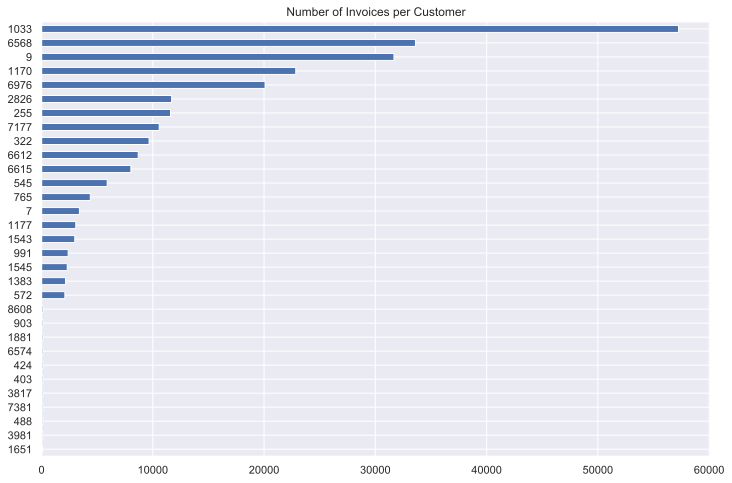

In [47]:
final['customer_id'].value_counts().sort_values().plot(kind='barh',
                                                       figsize=(12, 8),
                                                       title="Number of Invoices per Customer")

On this chart we can see that most of the invoices come from just 5 clients.

In [48]:
final['client_accounting_currency'].unique()

array(['GBP', 'EUR'], dtype=object)

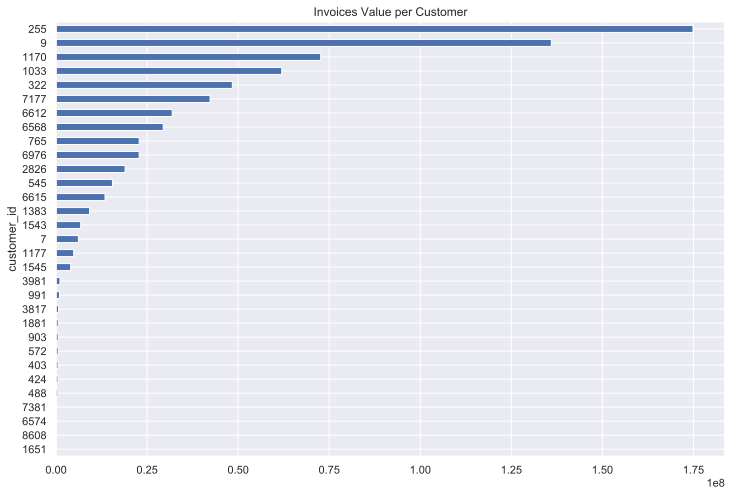

In [49]:
final.groupby('customer_id')['invoice_amount'].agg('sum').sort_values().plot(kind='barh',
                                                                             figsize=(12, 8),
                                                                             title="Invoices Value per Customer")

Although, looking at the sum of invoice amounts per client, we can see that clients with lower number of invoices might have larger total monetary value in invoices. For example, clients 9 and 255 have nearly two and three times less invoices than client 1033, but the monetary value of their invoices is double in value.

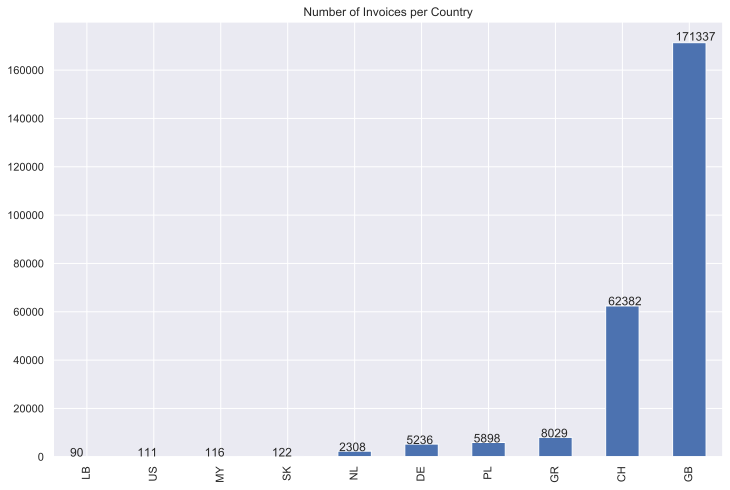

In [50]:
ax = final['client_customer_region'].value_counts().sort_values().plot(kind='bar',
                                                                  figsize=(12, 8),
                                                                  title="Number of Invoices per Country")

# differences in number of invoices per region are too high, so annotations help us
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

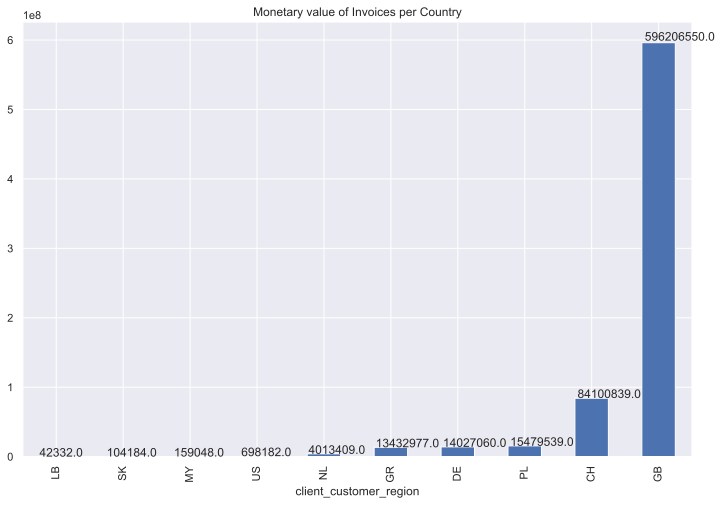

In [51]:
ax = final.groupby('client_customer_region')['invoice_amount'].agg('sum').round().sort_values().plot(kind='bar',
                                                                  figsize=(12, 8),
                                                                  title="Monetary value of Invoices per Country")

# differences in number of invoices per region are too high, so annotations help us
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

Most of the invoices come from the UK and Swizterland. The graph that shows monetary value of the invoices didn't uncover anything sygnificant apart from the fact that some countries changed their places in terms of sorting. For example, Poland and Germany bring more monetary value than Greece.

In [52]:
final.astype({'Early_late_days': 'timedelta64[D]'}).boxplot(vert=False, column='Early_late_days', by='customer_id', 
              figsize=(12, 8))

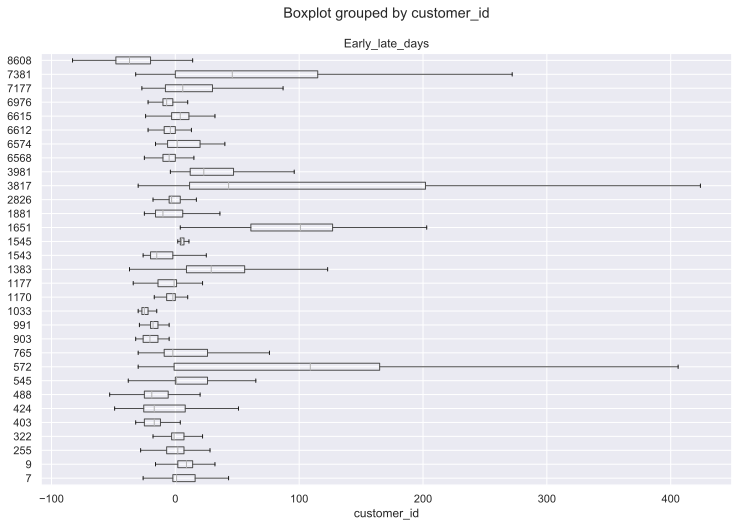

In [53]:
# the same but without outliers to better see when most of the clients make most of the payments
final.astype({'Early_late_days': 'timedelta64[D]'}).boxplot(vert=False, column='Early_late_days', by='customer_id', 
              figsize=(12, 8), showfliers=False)

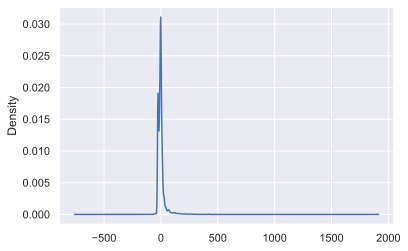

In [54]:
final['Early_late_days'].astype('timedelta64[D]').plot.kde()

In [ ]:
# distribution is highly skewed, so we can use log scales to make visualisation clearer
# plot log scaled distribution of the early late payments
fig, ax = plt.subplots()
final['Early_late_days'].astype('timedelta64[D]').hist(ax=ax, bins=150, bottom=0.1)
plt.title('Distribution of Early (0 and further left) and Late (further right from 0) Payments')
plt.xlabel('Early Late Payments in Days')
ax.set_yscale('log')

The box plot looks a bit messy, but we can see that all of the clients occasionally make late payments. Some of them 
have late payments more often, so clients in cases of which boxes (representing quartiles 1 to 3) are positioned 
after 0 days mark meaning that they are often late with their payments. It is very apparent in case of clients 7381, 
3817, 1651, 1383, and 572. We can also see clients that are early or on time with their payments most of the time, 
although with a few outliers in terms of late payments. For example, in case of clients 488, 403, 8608.

Clients that have the most number of invoices or the highest total monetary value of their invoices (255, 1170, 1033) 
are mostly on time with their payments, although with a few outliers in terms of late payments. Client 9 is often 
a little late with payments. Although, as said earlier, 66% of payments are made on time or earlier and looking 
at the density plot we can see that most likely the payments are made at the due date or just around it.

### 5. Model
Run a model (machine learning algorithm) to predict the probability a given invoice will be repaid late. Make
sure to use a training/testing framework where you never use data from the future to predict a value from
the past. We don’t expect you to spend lots of time selecting which algorithm works best on the data set or
tuning hyperparameters. You will be assessed on approach rather than model performance.

a. Plot some graphs/tables to show how well the model fits the data. Comment on what you see in
these.

b. What could you tell a client about the model you chose and your thinking behind it?

c. How should we use this probability to make financing decisions?

In [56]:
print(final.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 255629 entries, 3094734.0 to 4447401.0
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   entered_date                255629 non-null  datetime64[ns] 
 1   paid_date                   255629 non-null  datetime64[ns] 
 2   client_customer_id          255629 non-null  int64          
 3   invoice_amount              255629 non-null  float64        
 4   client_region               255629 non-null  int64          
 5   payment_terms               255629 non-null  int64          
 6   client_accounting_currency  255629 non-null  object         
 7   is_late                     255629 non-null  int32          
 8   Early_late_days             255629 non-null  timedelta64[ns]
 9   customer_id                 255629 non-null  int64          
 10  client_customer_city        104350 non-null  object         
 11  client_custom

As seen from the non-null count, the client customer city has less than half non-null values. 

In [67]:
# choose cities where we have clients
final[~final['client_customer_city'].isna()].client_customer_city.unique()

array(['Camberley', 'Manchester', 'London', 'Avon', 'Kettering',
       'Prenton', 'Edinburgh', 'Glasgow', 'Belfast', 'Swindon',
       'Unterschleissheim', 'Alphen aan den Rijn', 'Wallisellen-Zuerich',
       'Newport  Gwent', 'Kuala Lumpur', 'Anthoussa', 'BRATISLAVA'],
      dtype=object)

In [68]:
# choose regions where we have clients
final[~final['client_customer_city'].isna()].client_customer_region.unique()

array(['GB', 'DE', 'NL', 'MY', 'GR', 'SK'], dtype=object)

Interestingly, if we select invoices that have non-null value in client_customer_city column, we get a list of cities and one of them is Wallisellen-Zuerich which is a city near Zurich in Switzerland. Although, when we look at the unique regions from the same subset of data, we don't get CH (Switzerland) as one of the regions.

In [70]:
final[final['client_customer_city'] == 'Wallisellen-Zuerich'].client_customer_region.unique()

array(['GB'], dtype=object)

If we select the region that is associated with this city, then we can see only GB (Great Britain) which doesn't look right. It could be a mistake or not. Lets look at the Customer Master table.

In [71]:
customer_master

customer_id  client_customer_id  client_subentity client_customer_city  \
0             7            60000075                60            Camberley   
1             9            60000077                60           Manchester   
2           255            60002624                60                  NaN   
3           322            60001699                60               London   
4           403            60003169                60                 Avon   
5           424            60003090                60            Kettering   
6           488            60003204                60              Prenton   
7           545            60003887                60                  NaN   
8           572            60004010                60            Edinburgh   
9           765            60004941                60              Glasgow   
10          903            60005204                60              Swindon   
11          991            60005455                60              Belfast   
12         1033            60005903                60                  NaN   
13         1170            60006285                60                 Avon   
14         1177            61000089                61    Unterschleissheim   
15         1383            66000079                66                  NaN   
16         1543            60006398                60               London   
17         1545            76000464                76  Alphen aan den Rijn   
18         1651            50001712                50                  NaN   
19         1881            60006465                60       Newport  Gwent   
20         2826            50002632                50                  NaN   
21         3817            50003662                50                  NaN   
22         3981            50003240                50                  NaN   
23         6568            60007454                60                  NaN   
24         6574            50004048                50         Kuala Lumpur   
25         6612            87000135                87                  NaN   
26         6615            87000138                87            Anthoussa   
27         6976            60007460                60                  NaN   
28         7177            92001377                92               London   
29         7381            92001425                92  Wallisellen-Zuerich   
30         8608            50006297                50           BRATISLAVA   

   client_customer_region          customer_payment_terms  \
0                      GB           100%-30-Days/NA-NA-NA   
1                      GB           100%-90-Days/NA-NA-NA   
2                      GB           100%-60-Days/NA-NA-NA   
3                      GB           100%-45-Days/NA-NA-NA   
4                      GB           100%-60-Days/NA-NA-NA   
5                      GB           100%-60-Days/NA-NA-NA   
6                      GB           100%-60-Days/NA-NA-NA   
7                      PL           100%-60-Days/NA-NA-NA   
8                      GB           100%-30-Days/NA-NA-NA   
9                      GB           100%-30-Days/NA-NA-NA   
10                     GB           100%-60-Days/NA-NA-NA   
11                     GB           100%-30-Days/NA-NA-NA   
12                     GB           100%-30-Days/NA-NA-NA   
13                     GB           100%-45-Days/NA-NA-NA   
14                     DE           100%-30-Days/NA-NA-NA   
15                     DE           100%-45-Days/NA-NA-NA   
16                     GB           100%-30-Days/NA-NA-NA   
17                     NL           100%-30-Days/NA-NA-NA   
18                     LB           100%-30-Days/NA-NA-NA   
19                     GB           100%-30-Days/NA-NA-NA   
20                     GB           100%-30-Days/NA-NA-NA   
21                     US           100%-30-Days/NA-NA-NA   
22                     GB           100%-60-Days/NA-NA-NA   
23                     CH           100%-45

We can see that a lot of clients have NaNs as their city and it would be hard/impossible to deduce how to substitute this data without further information, so it would be reasonable to just drop that column because machine learning algorithms usually don't like missing data and there is no way to logically fill NaNs here.

Another interesting data artefact that could be spotted here is that customer from BRATISLAVA is the only one with city name written in capital letters and the only one that has different client_payment_instrument (H not A). Besides, the client has unique customer_payment_terms expressed in months and days (3 Months - 30 days) while all of the other clients have this data specified in days only.

This unique customer payment term looks like a mistake and it should be either substituted with 120 days (4 months) or 90 days, assuming that 30 days got there by a mistake. Although, this could be correct, and I just don't have enough information.

For modelling purposes, categorical text data like in the customer_payment_terms should be transformed into a numerical format. It's unclear, what is the best way to go about the client from Bratislava. Whether to put 90days there and put him in the same category as some other clients, leave him as is, and give him separate category or to put there 120 days and again give him separate category.

Since it's unclear whether it's an actual mistake or not, I will put him in a separate category. 

In [57]:
final.head()

entered_date  paid_date  client_customer_id  \
gardenia_invoice_id                                               
3094734.0             2016-10-27 2017-01-06            60002624   
3094937.0             2016-10-27 2017-01-06            60002624   
3094939.0             2016-10-27 2017-01-06            60002624   
3094960.0             2016-10-27 2017-01-06            60002624   
3094962.0             2016-10-27 2017-01-06            60002624   

                     invoice_amount  client_region  payment_terms  \
gardenia_invoice_id                                                 
3094734.0                   2282.20             60              3   
3094937.0                   1916.54             60              3   
3094939.0                    282.13             60              3   
3094960.0                  10395.92             60              3   
3094962.0                   5789.10             60              3   

                    client_accounting_currency  is_late Early_late_days  \
gardenia_invoice_id                                                       
3094734.0                                  GBP        1         11 days   
3094937.0                                  GBP        1         11 days   
3094939.0                                  GBP        1         11 days   
3094960.0                                  GBP        1         11 days   
3094962.0                                  GBP        1         11 days   

                     customer_id client_customer_city client_customer_region  \
gardenia_invoice_id                                                            
3094734.0                    255                  NaN                     GB   
3094937.0                    255                  NaN                     GB   
3094939.0                    255                  NaN                     GB   
3094960.0                    255                  NaN                     GB   
3094962.0                    255                  NaN                     GB   

                    customer_payment_terms client_payment_instrument  \
gardenia_invoice_id                                                    
3094734.0            100%-60-Days/NA-NA-NA                         A   
3094937.0            100%-60-Days/NA-NA-NA                         A   
3094939.0            100%-60-Days/NA-NA-NA                         A   
3094960.0            100%-60-Days/NA-NA-NA                         A   
3094962.0            100%-60-Days/NA-NA-NA                         A   

                     late_ratio  late_ratio_90  late_ratio_180  
gardenia_invoice_id                                             
3094734.0              0.504586       0.785088        0.797267  
3094937.0              0.504586       0.785088        0.797267  
3094939.0              0.504586       0.785088        0.797267  
3094960.0              0.504586       0.785088        0.797267  
3094962.0              0.504586       0.785088        0.797267

In [75]:
# drop the client_customer_city column
final = final.drop(columns='client_customer_city', axis=1)
print(final.info())  # verify we dropped the column

<class 'pandas.core.frame.DataFrame'>
Float64Index: 255629 entries, 3094734.0 to 4447401.0
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   entered_date                255629 non-null  datetime64[ns] 
 1   paid_date                   255629 non-null  datetime64[ns] 
 2   client_customer_id          255629 non-null  int64          
 3   invoice_amount              255629 non-null  float64        
 4   client_region               255629 non-null  int64          
 5   payment_terms               255629 non-null  int64          
 6   client_accounting_currency  255629 non-null  object         
 7   is_late                     255629 non-null  int32          
 8   Early_late_days             255629 non-null  timedelta64[ns]
 9   customer_id                 255629 non-null  int64          
 10  client_customer_region      255629 non-null  object         
 11  customer_paym

In [58]:
final.customer_payment_terms.unique()

array(['100%-60-Days/NA-NA-NA', '100%-30-Days/NA-NA-NA',
       '100%-90-Days/NA-NA-NA', '100%-45-Days/NA-NA-NA',
       '100%-3-Months-30-Days/NA-NA-NA'], dtype=object)

In [76]:
final.client_accounting_currency.unique()

array(['GBP', 'EUR'], dtype=object)

In [77]:
final.client_customer_region.unique()

array(['GB', 'PL', 'DE', 'NL', 'US', 'LB', 'MY', 'CH', 'GR', 'SK'],
      dtype=object)

In [79]:
final.client_payment_instrument.unique()

array(['A', 'H'], dtype=object)

In [82]:
# now all of our columns have only non-null values and we need to transform categorical data into numerical categories
# encoding the data
encods = {"customer_payment_terms": {"100%-60-Days/NA-NA-NA": 60, 
                                     "100%-30-Days/NA-NA-NA": 30,
                                     "100%-90-Days/NA-NA-NA": 90,
                                     "100%-45-Days/NA-NA-NA": 45,
                                     "100%-3-Months-30-Days/NA-NA-NA": 120},
          "client_accounting_currency": {"GBP": 1, "EUR": 2},
          "client_customer_region": {"GB": 1,
                                     "PL": 2,
                                     "DE": 3,
                                     "NL": 4,
                                     "US": 5,
                                     "LB": 6,
                                     "MY": 7,
                                     "CH": 8,
                                     "GR": 9,
                                     "SK": 10},
         "client_payment_instrument": {"A": 1,
                                       "H": 2}}

In [80]:
final_e = final.copy()

In [83]:
final_e.replace(encods, inplace=True)
final_e.tail()

entered_date  paid_date  client_customer_id  \
gardenia_invoice_id                                               
3094734.0             2016-10-27 2017-01-06            60002624   
3094937.0             2016-10-27 2017-01-06            60002624   
3094939.0             2016-10-27 2017-01-06            60002624   
3094960.0             2016-10-27 2017-01-06            60002624   
3094962.0             2016-10-27 2017-01-06            60002624   

                     invoice_amount  client_region  payment_terms  \
gardenia_invoice_id                                                 
3094734.0                   2282.20             60              3   
3094937.0                   1916.54             60              3   
3094939.0                    282.13             60              3   
3094960.0                  10395.92             60              3   
3094962.0                   5789.10             60              3   

                     client_accounting_currency  is_late Early_late_days  \
gardenia_invoice_id                                                        
3094734.0                                     1        1         11 days   
3094937.0                                     1        1         11 days   
3094939.0                                     1        1         11 days   
3094960.0                                     1        1         11 days   
3094962.0                                     1        1         11 days   

                     customer_id  client_customer_region  \
gardenia_invoice_id                                        
3094734.0                    255                       1   
3094937.0                    255                       1   
3094939.0                    255                       1   
3094960.0                    255                       1   
3094962.0                    255                       1   

                     customer_payment_terms  client_payment_instrument  \
gardenia_invoice_id                                                      
3094734.0                                60                          1   
3094937.0                                60                          1   
3094939.0                                60                          1   
3094960.0                                60                          1   
3094962.0                                60                          1   

                     late_ratio  late_ratio_90  late_ratio_180  
gardenia_invoice_id                                             
3094734.0              0.504586       0.785088        0.797267  
3094937.0              0.504586       0.785088        0.797267  
3094939.0              0.504586       0.785088        0.797267  
3094960.0              0.504586       0.785088        0.797267  
3094962.0              0.504586       0.785088        0.797267

In [85]:
final_e.tail()

entered_date  paid_date  client_customer_id  \
gardenia_invoice_id                                               
4447397.0             2017-12-11 2018-03-21            50006297   
4447398.0             2017-12-11 2018-03-21            50006297   
4447399.0             2018-01-17 2018-03-21            50006297   
4447400.0             2018-02-06 2018-03-21            50006297   
4447401.0             2018-02-06 2018-03-21            50006297   

                     invoice_amount  client_region  payment_terms  \
gardenia_invoice_id                                                 
4447397.0                    132.00             50             12   
4447398.0                    797.55             50             12   
4447399.0                    782.55             50             12   
4447400.0                   1950.00             50             12   
4447401.0                   3030.10             50             12   

                     client_accounting_currency  is_late Early_late_days  \
gardenia_invoice_id                                                        
4447397.0                                     1        0        -10 days   
4447398.0                                     1        0        -10 days   
4447399.0                                     1        0        -40 days   
4447400.0                                     1        0        -71 days   
4447401.0                                     1        0        -71 days   

                     customer_id  client_customer_region  \
gardenia_invoice_id                                        
4447397.0                   8608                      10   
4447398.0                   8608                      10   
4447399.0                   8608                      10   
4447400.0                   8608                      10   
4447401.0                   8608                      10   

                     customer_payment_terms  client_payment_instrument  \
gardenia_invoice_id                                                      
4447397.0                               120                          2   
4447398.0                               120                          2   
4447399.0                               120                          2   
4447400.0                               120                          2   
4447401.0                               120                          2   

                     late_ratio  late_ratio_90  late_ratio_180  
gardenia_invoice_id                                             
4447397.0              0.169811            0.0             0.0  
4447398.0              0.169811            0.0             0.0  
4447399.0              0.157895            0.0             0.0  
4447400.0              0.157895            0.0             0.0  
4447401.0              0.157895            0.0             0.0

In [84]:
final_e.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 255629 entries, 3094734.0 to 4447401.0
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   entered_date                255629 non-null  datetime64[ns] 
 1   paid_date                   255629 non-null  datetime64[ns] 
 2   client_customer_id          255629 non-null  int64          
 3   invoice_amount              255629 non-null  float64        
 4   client_region               255629 non-null  int64          
 5   payment_terms               255629 non-null  int64          
 6   client_accounting_currency  255629 non-null  int64          
 7   is_late                     255629 non-null  int32          
 8   Early_late_days             255629 non-null  timedelta64[ns]
 9   customer_id                 255629 non-null  int64          
 10  client_customer_region      255629 non-null  int64          
 11  customer_paym

In [86]:
# now we need to change timedelta into numerical values
final_e['Early_late_days_i'] = final_e['Early_late_days'].dt.days.astype('int32')
print(final_e.tail())

                    entered_date  paid_date  client_customer_id  \
gardenia_invoice_id                                               
4447397.0             2017-12-11 2018-03-21            50006297   
4447398.0             2017-12-11 2018-03-21            50006297   
4447399.0             2018-01-17 2018-03-21            50006297   
4447400.0             2018-02-06 2018-03-21            50006297   
4447401.0             2018-02-06 2018-03-21            50006297   

                     invoice_amount  client_region  payment_terms  \
gardenia_invoice_id                                                 
4447397.0                    132.00             50             12   
4447398.0                    797.55             50             12   
4447399.0                    782.55             50             12   
4447400.0                   1950.00             50             12   
4447401.0                   3030.10             50             12   

                     client_accounting_currenc

In [87]:
final_e.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 255629 entries, 3094734.0 to 4447401.0
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   entered_date                255629 non-null  datetime64[ns] 
 1   paid_date                   255629 non-null  datetime64[ns] 
 2   client_customer_id          255629 non-null  int64          
 3   invoice_amount              255629 non-null  float64        
 4   client_region               255629 non-null  int64          
 5   payment_terms               255629 non-null  int64          
 6   client_accounting_currency  255629 non-null  int64          
 7   is_late                     255629 non-null  int32          
 8   Early_late_days             255629 non-null  timedelta64[ns]
 9   customer_id                 255629 non-null  int64          
 10  client_customer_region      255629 non-null  int64          
 11  customer_paym

In [88]:
# all of our columns are numeric and we can delete early_late_days (timedelta) column
final_e = final_e.drop(columns='Early_late_days', axis=1)
print(final_e.info())  # verify we dropped the column

<class 'pandas.core.frame.DataFrame'>
Float64Index: 255629 entries, 3094734.0 to 4447401.0
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   entered_date                255629 non-null  datetime64[ns]
 1   paid_date                   255629 non-null  datetime64[ns]
 2   client_customer_id          255629 non-null  int64         
 3   invoice_amount              255629 non-null  float64       
 4   client_region               255629 non-null  int64         
 5   payment_terms               255629 non-null  int64         
 6   client_accounting_currency  255629 non-null  int64         
 7   is_late                     255629 non-null  int32         
 8   customer_id                 255629 non-null  int64         
 9   client_customer_region      255629 non-null  int64         
 10  customer_payment_terms      255629 non-null  int64         
 11  client_payment_instrument 

In [92]:
g = sns.pairplot(final_e, hue='is_late', 
                 vars=['invoice_amount', 'Early_late_days_i', 'late_ratio', 'late_ratio_90', 'late_ratio_180']);

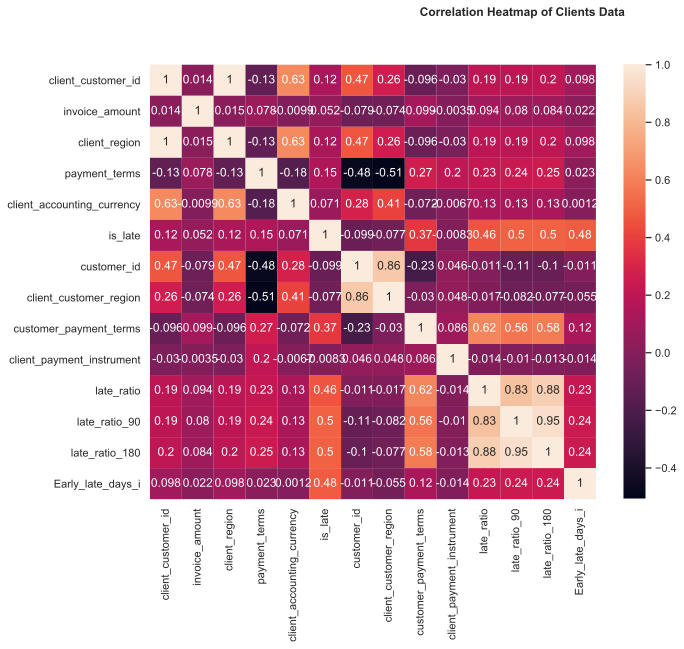

In [94]:
# correlation matrix
corrmat = final_e.corr();
fig, ax = plt.subplots(figsize=(10, 8));
sns.heatmap(corrmat, annot=True);
fig.suptitle('Correlation Heatmap of Clients Data', 
             fontsize=12, fontweight='bold', ha='left');

Most of all, we are interested in is_late column, our target variable, and from the correlation matrix we can see that it has some moderate positive correlation with late_ratios columns, Early_late_days and a slightly weaker positive correlation with customer_payment_terms column. Client accounting currency has positive correlation with client customer region. Customer payment terms has positive correlations with late ratios columns. Late ratios columns are highly correlated among each other.

Overall, the correlation matrix doesn't uncover any unexpected relations.

The goal is to predict the probability of a late invoice repayment. Since we have two categories (late / not late) this makes it a classification problem where we try to predict the probability of an invoice falling into a late or not late category. In scikit-learn we can use predict-proba methods to make probability predictions.

# Note

# use one-hot encoding. where you split categorical data among columns with categories as labels and put 1 for True and 0 for false.

### 6. Optional extras
These are not part of the core part of the exercise, but if you finish early feel free to attempt them for
bonus credit. You are not expected to complete them in order to progress to the next stage of the interview
process so do not worry if you don’t have time for them.

a. Are there any features of the data that seem to correlate to late payment? Are there interesting
features you would remark on?

b. Are there any areas in which your model is doing particularly well/badly?